In [0]:
%config InlineBackend.figure_format = 'retina'

import math
import random
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [0]:
class BaseEstimator(object):
    '''
    Digunakan untuk memastikan input memenuhi kriteria.
    - Memastikan X disimpan dalam bentuk numpy ndarrays.

    Parameter
    ---------
    X : (array-like) Feature dataset.
    '''
    X = None
    fit_required = True

    def _setup_input(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Number of features must be > 0")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

    def fit(self, X):
        self._setup_input(X)

    def _predict(self, X):
        raise NotImplementedError()

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

In [0]:
def euclidean_distance(a, b):
    if isinstance(a, list) and isinstance(b, list):
        a = np.array(a)
        b = np.array(b)

    return math.sqrt(sum((a - b) ** 2))
    
class KMeans(BaseEstimator):
    """
    Class KMeans akan digunakan sebagai salah satu inisialisasi nilai awal dari 
    algoritma gaussian mixture model
    """

    y_required = False

    def __init__(self, K=5, max_iters=100, init="random"):
        self.K = K
        self.max_iters = max_iters
        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []
        self.init = init

    def _initialize_centroids(self, init):
        """Inisialisasi centroid."""
        if init == "random":
            self.centroids = [self.X[x] for x in random.sample(range(self.n_samples), self.K)]
        elif init == "++":
            self.centroids = [random.choice(self.X)]
            while len(self.centroids) < self.K:
                self.centroids.append(self._choose_next_center())
        else:
            raise ValueError("Unknown type of init parameter")

    def _predict(self, X=None):
        """melakukan clustering pada data."""
        self._initialize_centroids(self.init)
        centroids = self.centroids

        # Optimize clusters
        for _ in range(self.max_iters):
            self._assign(centroids)
            centroids_old = centroids
            centroids = [self._get_centroid(cluster) for cluster in self.clusters]

            if self._is_converged(centroids_old, centroids):
                break

        self.centroids = centroids

        return self._get_predictions()

    def _get_predictions(self):
        predictions = np.empty(self.n_samples)

        for i, cluster in enumerate(self.clusters):
            for index in cluster:
                predictions[index] = i
        return predictions

    def _assign(self, centroids):
        for row in range(self.n_samples):
            for i, cluster in enumerate(self.clusters):
                if row in cluster:
                    self.clusters[i].remove(row)
                    break

            closest = self._closest(row, centroids)
            self.clusters[closest].append(row)

    def _closest(self, fpoint, centroids):
        """Mendapatkan centroid terdekat dari suatu datapoint"""
        closest_index = None
        closest_distance = None
        for i, point in enumerate(centroids):
            dist = euclidean_distance(self.X[fpoint], point)
            if closest_index is None or dist < closest_distance:
                closest_index = i
                closest_distance = dist
        return closest_index

    def _get_centroid(self, cluster):
        """Mendapatkan mean dari centroid."""
        return [np.mean(np.take(self.X[:, i], cluster)) for i in range(self.n_features)]

    def _dist_from_centers(self):
        """Menghitung jarak dari centroid."""
        return np.array([min([euclidean_distance(x, c) for c in self.centroids]) for x in self.X])

    def _choose_next_center(self):
        distances = self._dist_from_centers()
        squared_distances = distances ** 2
        probs = squared_distances / squared_distances.sum()
        ind = np.random.choice(self.X.shape[0], 1, p=probs)[0]
        return self.X[ind]

    def _is_converged(self, centroids_old, centroids):
        """Menghitung jarak centroid lama dengan yang baru."""
        distance = 0
        for i in range(self.K):
            distance += euclidean_distance(centroids_old[i], centroids[i])
        return distance == 0
    
    def plot(self, ax=None, holdon=False):
        sns.set(style="white")
        palette = sns.color_palette("hls", self.K + 1)
        data = self.X

        if ax is None:
            _, ax = plt.subplots()

        for i, index in enumerate(self.clusters):
            point = np.array(data[index]).T
            ax.scatter(*point, c=[palette[i], ])

        for point in self.centroids:
            ax.scatter(*point, marker="x", linewidths=10)

        if not holdon:
            plt.show()

In [0]:
SELECTED_COLS = ['bathrooms', 'waterfront', 'sqft_above', 'sqft_living15', 'grade', 
                 'yr_renovated', 'price', 'bedrooms', 'long', 'sqft_lot15', 'sqft_living', 
                 'condition', 'lat', 'sqft_basement', 'yr_built', 'sqft_lot', 'view']
                 
raw_dataset = pd.read_csv(
    'https://raw.githubusercontent.com/Jonasyao/Machine-Learning-Specialization-University-of-Washington-/master/Regression/Assignment_four/kc_house_data.csv',
    dtype={'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 
           'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 
           'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 
           'floors':str, 'condition':int, 'lat':float, 'date':str, 
           'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int},
    na_values = "NaN",
    usecols = SELECTED_COLS,
    sep=",", 
    skipinitialspace=True 
)

In [0]:
# drop is na

clean_dataset = raw_dataset.dropna()

In [6]:
# memerika missing value 

clean_dataset.isnull().sum().max()

0

In [0]:
features = SELECTED_COLS
price_col = features.pop(6)

In [0]:
correlation={}
for f in features:
    data1 = clean_dataset[[f,price_col]]
    x1= data1[f].values
    x2= data1[price_col].values
    key = f
    correlation[key] = pearsonr(x1,x2)[0]

In [9]:
## Mengurutkan korelasi terhadap price

data_correlations = pd.DataFrame(correlation, index=['Value']).T
sorted_data_correlations = data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]
sorted_data_correlations

,Value
sqft_living,0.705048
grade,0.654124
sqft_living15,0.607973
sqft_above,0.599095
bathrooms,0.525509
view,0.443541
waterfront,0.366537
sqft_basement,0.348599
lat,0.301254
bedrooms,0.292742


In [10]:
# Mengambbil 5 feature dengan korelasi tertinggi

SELECTED_COLS = sorted_data_correlations.T.columns[:5].tolist()
SELECTED_COLS.append(price_col)

SELECTED_COLS

['sqft_living', 'grade', 'sqft_living15', 'sqft_above', 'bathrooms', 'price']

In [0]:
clean_dataset = clean_dataset[SELECTED_COLS]

# Membuat cluster antara price dengan column lain

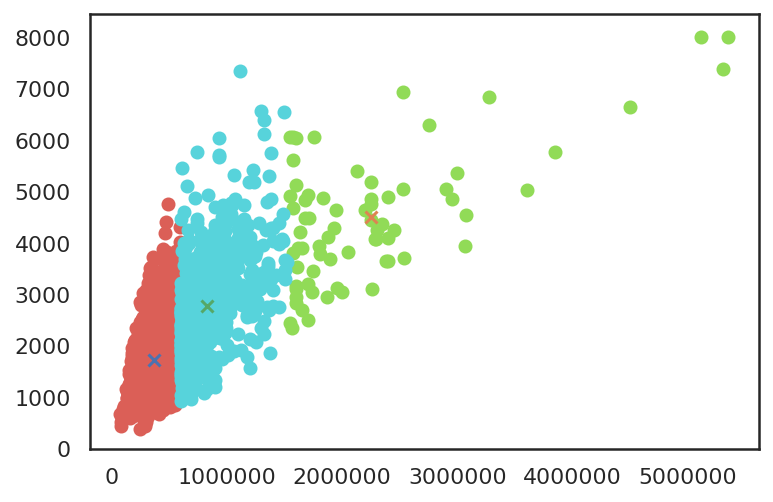

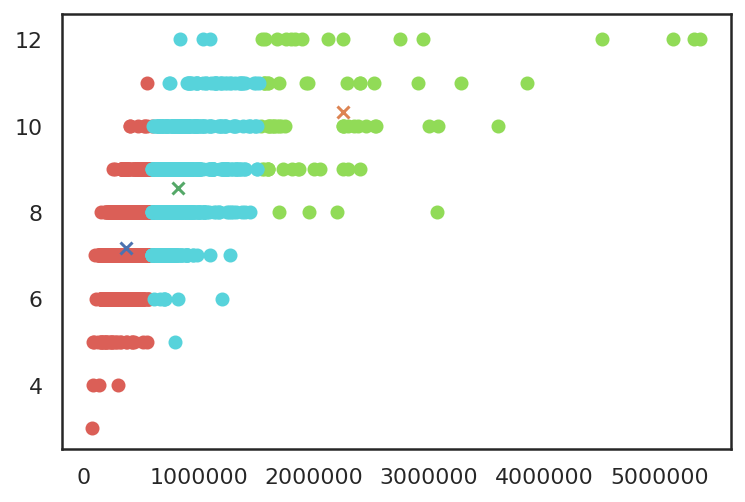

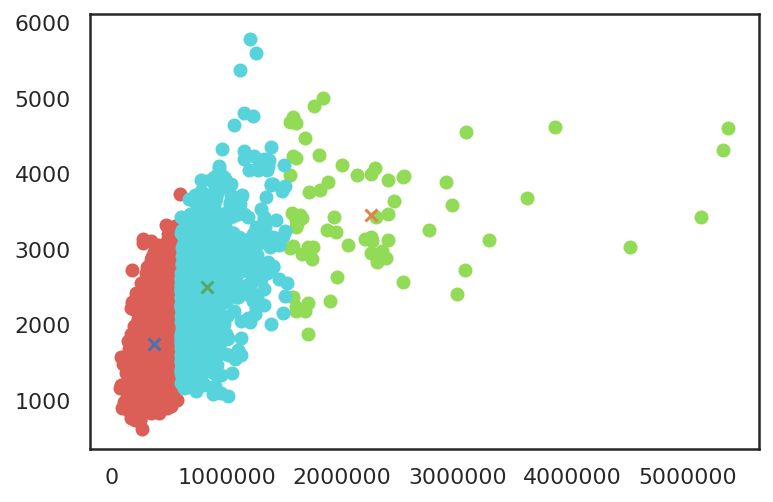

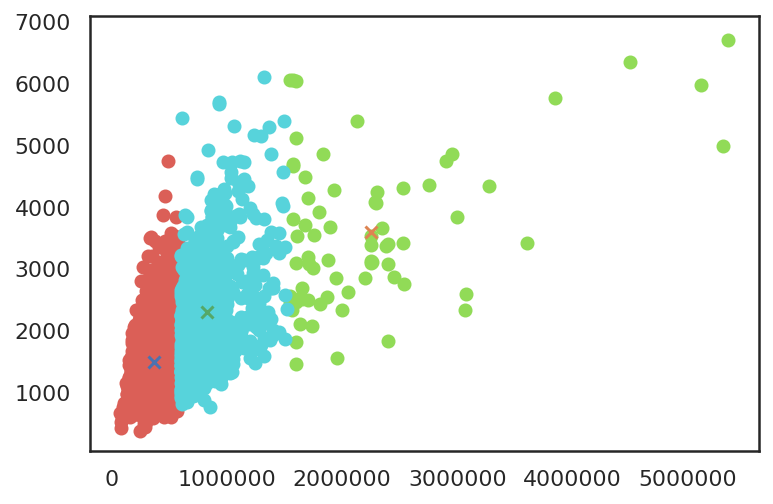

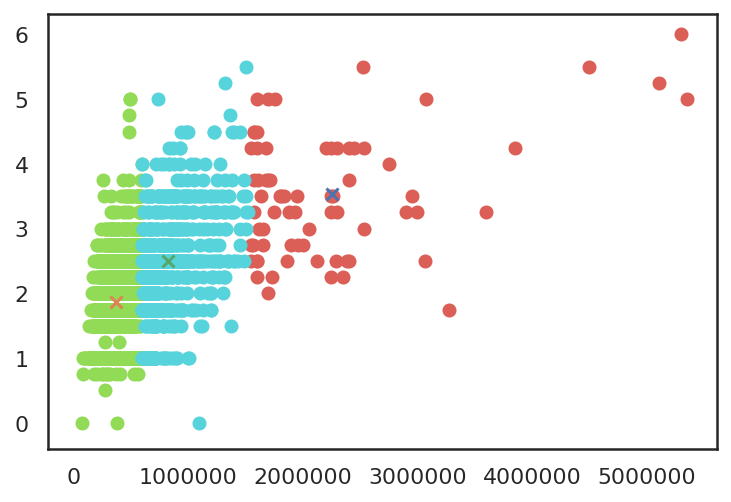

In [12]:
for f in SELECTED_COLS[:-1]:
    kmm = KMeans(K=3, max_iters=150, init="++")
    kmm.fit(clean_dataset[[price_col, f]])
    labels = kmm.predict()
    kmm.plot()

# Clustering untuk Feature Lebih dari 2

In [0]:
kmm = KMeans(K=3, max_iters=150, init="++")
kmm.fit(clean_dataset[[price_col, f]])
labels = kmm.predict()

In [14]:
clean_dataset['labels'] = labels
clean_dataset

,sqft_living,grade,sqft_living15,sqft_above,bathrooms,price,labels
0,1180.0,7,1340.0,1180,1.00,221900.0,0.0
1,2570.0,7,1690.0,2170,2.25,538000.0,0.0
2,770.0,6,2720.0,770,1.00,180000.0,0.0
3,1960.0,7,1360.0,1050,3.00,604000.0,0.0
4,1680.0,8,1800.0,1680,2.00,510000.0,0.0
...,...,...,...,...,...,...,...
3159,1630.0,7,1600.0,1630,1.75,431000.0,0.0
3160,1840.0,8,1970.0,1340,2.50,485000.0,0.0
3161,1620.0,8,2440.0,1620,1.50,780000.0,2.0
3162,1840.0,8,1880.0,1340,1.50,720000.0,2.0
